# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. We are using the datset provided in the I'm Something of a Painter Myself competition

* The code for this notebook relies heavilt on tutorials posted on Kaggle
* It looks like this project does not count for any points so I am working my way through the tutorials to understand it
* The code is  modified from the tutorials so I can see the impact of tweaking parameters


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2022-06-17 00:16:47.972260: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-17 00:16:47.972373: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-06-17 00:16:53.098014: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-17 00:16:53.100808: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-17 00:16:53.100843: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-17 00:16:53.100870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01d5bf510049): /proc/driver/nvidia/version does not exist
2022-06-17 00:16:53.104749: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
GCS_PATH

'gs://kds-5947fb94d6799b645d7b9bec17151d0ea4fdc77081f8cf7decb28ddc'

In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-06-17 00:17:00.461494: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-06-17 00:17:00.541818: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


* Per information about the competition, the images are already sized at 256 by 256 and have 3 channels.
* We are reshaping the image into a tensor as with the same dimensions
* The fact that the reshape works without throwing an error shows that the dimensions are compatible
* The images scale will be 0 to 255, so we will rescale it to work with a -1 to 1 range

In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

* Grab the data from the competition data set

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

* Load the dataset

In [7]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

* Get some examples to look at

In [8]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

* Show the examples and some of their properies.

In [9]:
# This really isnt profound because we enforced the shape while loading but I wanted to show it
display(example_photo[0].shape)
display(example_monet[0].shape)

TensorShape([256, 256, 3])

TensorShape([256, 256, 3])

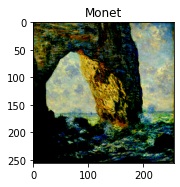

In [10]:
plt.figure(figsize=(15,15))
for (i,img) in enumerate(example_monet):
  if i==15: 
    break # just fixing an error
  plt.subplot(5, 3, i+1)
  plt.title("Monet")
  plt.imshow(img )

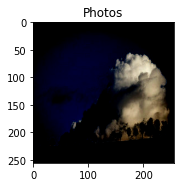

In [11]:
plt.figure(figsize=(15,15))
for (i,img) in enumerate(example_photo):
  if i==15: 
    break # just fixing an error
  plt.subplot(5, 3, i+1)
  plt.title("Photos")
  plt.imshow(img )

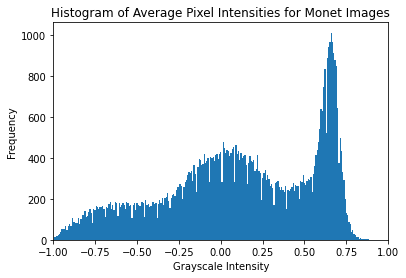

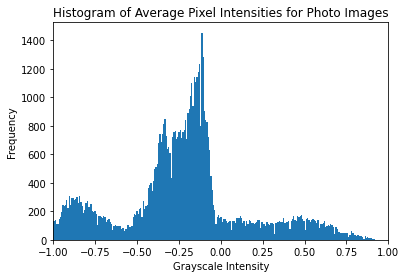

In [12]:
# Looking at a sample that I found in another notebook
monet_intensities = np.zeros(256*256)
for image in example_monet:
    monet_intensities += np.array(image).mean(axis=2).flatten()

b, bins, patches = plt.hist(monet_intensities / len(example_monet), 255)
plt.xlim([-1,1])
plt.title("Histogram of Average Pixel Intensities for Monet Images")
plt.xlabel("Grayscale Intensity")
plt.ylabel("Frequency")
plt.show()

no_intensities = np.zeros(256*256)
for image in example_photo:
  no_intensities += np.array(image).mean(axis=2).flatten()

b, bins, patches = plt.hist(no_intensities / len(example_photo), 255)
plt.title("Histogram of Average Pixel Intensities for Photo Images")
plt.xlabel("Grayscale Intensity")
plt.ylabel("Frequency")
plt.xlim([-1,1])
plt.show()


# Build the generator

* The CycleGAN generator uses the concept of upsample and downsample
* The downsample will reduce the dimenions to widthxhieght
* We are using a stride of 2 in our filter
* This is from sample code. Adjusting the stride didn't make things any better so I put it back


In [13]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

* Upsample reverses the downsample process

In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

* Now we are on to our generator
* We are using the data structure from sample code but experimented with changing the layers
* The general mantra of deep networks seems to be the more layers the merrier, so I experimented with addign layers with different filter sizes
* The additional layers caused issues with sampling because I messed up the shape,so I rolled back to a shape that works.
* I also experiemented with the dropout setting


In [15]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 1, 1, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(256, 4), # (bs, 32, 32, 256)
        upsample(256, 4), # (bs, 32, 32, 256)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

* A Cycle GAN uses two discriminators to convert images of two classes.
* This example uses Instance Normalization, ConvD, and LeakyReLU
* The sample code only had 2 Conv2FD and 1 LeakyReLU layers
* I added another set of layers and a dense layer to see if that would improve performance without a horrible increase in training time
* I am curious if the dense layer will help at all or if flattening will break things

In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv1 = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv1)

    leaky_relu1 = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu1) # (bs, 33, 33, 512)

    conv2 = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    
    leaky_relu2 = layers.LeakyReLU()(conv2)
    conv3 = tf.keras.layers.Conv2D(4, kernel_size=(3,3))(leaky_relu2)

    flat = tf.keras.layers.Flatten()(conv3)
    d1 = tf.keras.layers.Dense(128, activation="relu")(flat)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(d1)
    # fix variables

    return tf.keras.Model(inputs=inp, outputs=out)

In [17]:
with strategy.scope():
    # from sample code
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

* Take a look at what we have 
* Shouldnt be much because we havent trained it

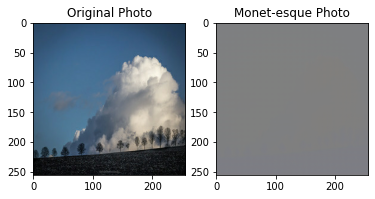

In [18]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

* I am using a class structure from sample code
* It is straight forward
* The intelligence is really in setting up the layers for the models and tuning the hyperparameters
* This just calls the other methods and measures loss in the generated images

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

* Use BinaryCrossentropy to measure loss between the real and generated image

In [20]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

* We want to make images that the discriminator thinks are real
* Even though we know it is fake, we want the network to think it meets criteria of real

In [21]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [22]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [23]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

* Fit the model that we previously built
* 

In [24]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [26]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 157s 161ms/step - monet_gen_loss: 6.0178 - photo_gen_loss: 6.7246 - monet_disc_loss: 0.6513 - photo_disc_loss: 0.5815
Epoch 2/25
  1/300 [..............................] - ETA: 1:00 - monet_gen_loss: 3.9730 - photo_gen_loss: 3.8670 - monet_disc_loss: 0.6413 - photo_disc_loss: 0.6946

2022-06-17 00:19:57.088891: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 14300, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1655425197.085638918","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 14300, Output num: 3","grpc_status":3}


300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 4.1096 - photo_gen_loss: 4.3043 - monet_disc_loss: 0.6770 - photo_disc_loss: 0.6439
Epoch 3/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.6943 - photo_gen_loss: 3.8046 - monet_disc_loss: 0.6746 - photo_disc_loss: 0.6264
Epoch 4/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.7321 - photo_gen_loss: 3.7765 - monet_disc_loss: 0.6407 - photo_disc_loss: 0.6182
Epoch 5/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.6752 - photo_gen_loss: 3.6756 - monet_disc_loss: 0.6285 - photo_disc_loss: 0.6346
Epoch 6/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.6071 - photo_gen_loss: 3.6284 - monet_disc_loss: 0.6129 - photo_disc_loss: 0.6168
Epoch 7/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.5668 - photo_gen_loss: 3.5705 - monet_disc_loss: 0.5771 - photo_dis

# Inspect the generated images

2022-06-17 00:39:38.071476: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 85522, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1655426378.071373168","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 85522, Output num: 0","grpc_status":3}


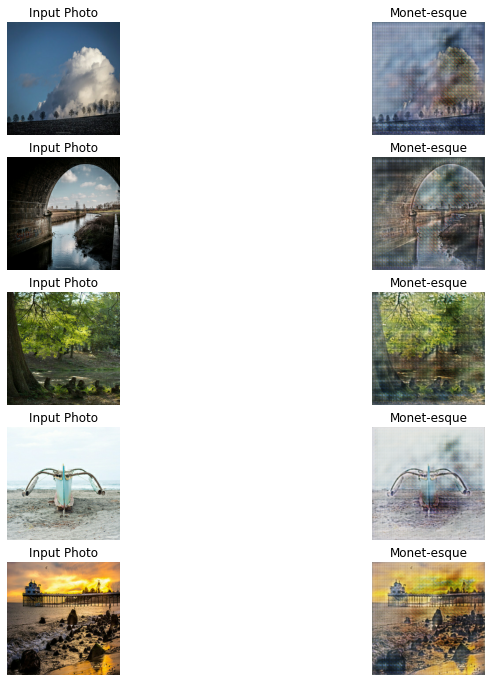

In [27]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [28]:
import PIL
! mkdir ../images

In [29]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-06-17 01:16:13.118267: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 4667269, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1655428573.118184369","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4667269, Output num: 0","grpc_status":3}


In [30]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

### Results and Discussion
* This is an interesting topic. My understanding is that we make changes and determine if those changes make a neural network think it looks closer to the training data for the target class or not
* We keep doing this until the changes to a photo are below a loss level to be considered like the training data
* I was sitting at my desk cheering for the changes in loss as I watched the model train
* The code the professor gave was interesting to help get started as were several articles on towardsdatascience and walk throughs on Kaggle
* This is the first topic in the course that was completely new to me
* Now that I am done with the coursework I am going to play with a few other GAN use cases

* One interesting thing I noticed is that with my deeper models, it looked more more like a painting but not a good one
* It was more of a copy of a copy of a copy with really bad quality. That isn't necessarily bad because the initial models still looked mostly like photos with a bit of blur. My last model just took blur too far
* I am going to label this as my own artistic style and submit the notebook with the blurry images instead of the models based more heavily on tutorials

* By following the example without modificatation, the score was 55.85414
* After starting with an example, I compared it with the instructor slides and walked through a few other examples
* I kept much of the "glue" code from the first example because it was mostly class setup
* I focused on editing the hyperparameters of the model and changing the layers
  * Some of my edits went full circle back 
  * Such as the upscaling and downscaling. I adjusted that back and forth and ended up keeping it as it was in the orginal example
* None of my edits improved on the score I got from Amy Yang's tutorial but it was fun to experiement with different options. 
* My score on the notebook with the fuzzy images that I am showing here was 110. I published this notebook because I liked the images despite the score.